In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from random import randint

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.functional.classification.jaccard import jaccard_index

from copy import deepcopy

from colorama import Fore

from WeatherNet.weathernet import WeatherNet

from dataloader.dataset import WADS
from dataloader.dataloader import WADSLoader

from SalsaNext.KNN import KNN

# Dataset

In [3]:
config = {'projection_H': 64,
          'projection_W': 2048,
          'sensor_fov_up': 3,
          'sensor_fov_down': -25,
          'sensor_img_means': [-12.12, -10.88, -0.23, -1.04, -0.21],
          'sensor_img_stds': [-12.32, -11.47, -6.91, -0.86, -0.16],
          'max_points': 250000}

In [4]:
train_ds = WADS("/tmp/wads_dataset/clean_dataset/Training/", config)
valid_ds = WADS("/tmp/wads_dataset/clean_dataset/Validation/", config)
test_ds = WADS("/tmp/wads_dataset/clean_dataset/Test/", config)

print("Number of training samples:", len(train_ds))
print("Number of validation samples:",len(valid_ds))
print("Number of test samples:",len(test_ds))

Number of training samples: 1316
Number of validation samples: 102
Number of test samples: 410


In [5]:
idx = 100
print(train_ds.scans[idx])
print(train_ds.labels[idx])

/tmp/wads_dataset/clean_dataset/Training/18/velodyne/040354.bin
/tmp/wads_dataset/clean_dataset/Training/18/labels/040354.label


In [6]:
sample = train_ds[idx]
print(sample.proj_xyz.shape)
print(sample.proj_range.shape)
print(sample.proj_remission.shape)
print(sample.proj_labels.shape)

torch.Size([3, 64, 2048])
torch.Size([1, 64, 2048])
torch.Size([1, 64, 2048])
torch.Size([1, 64, 2048])


# Projection result

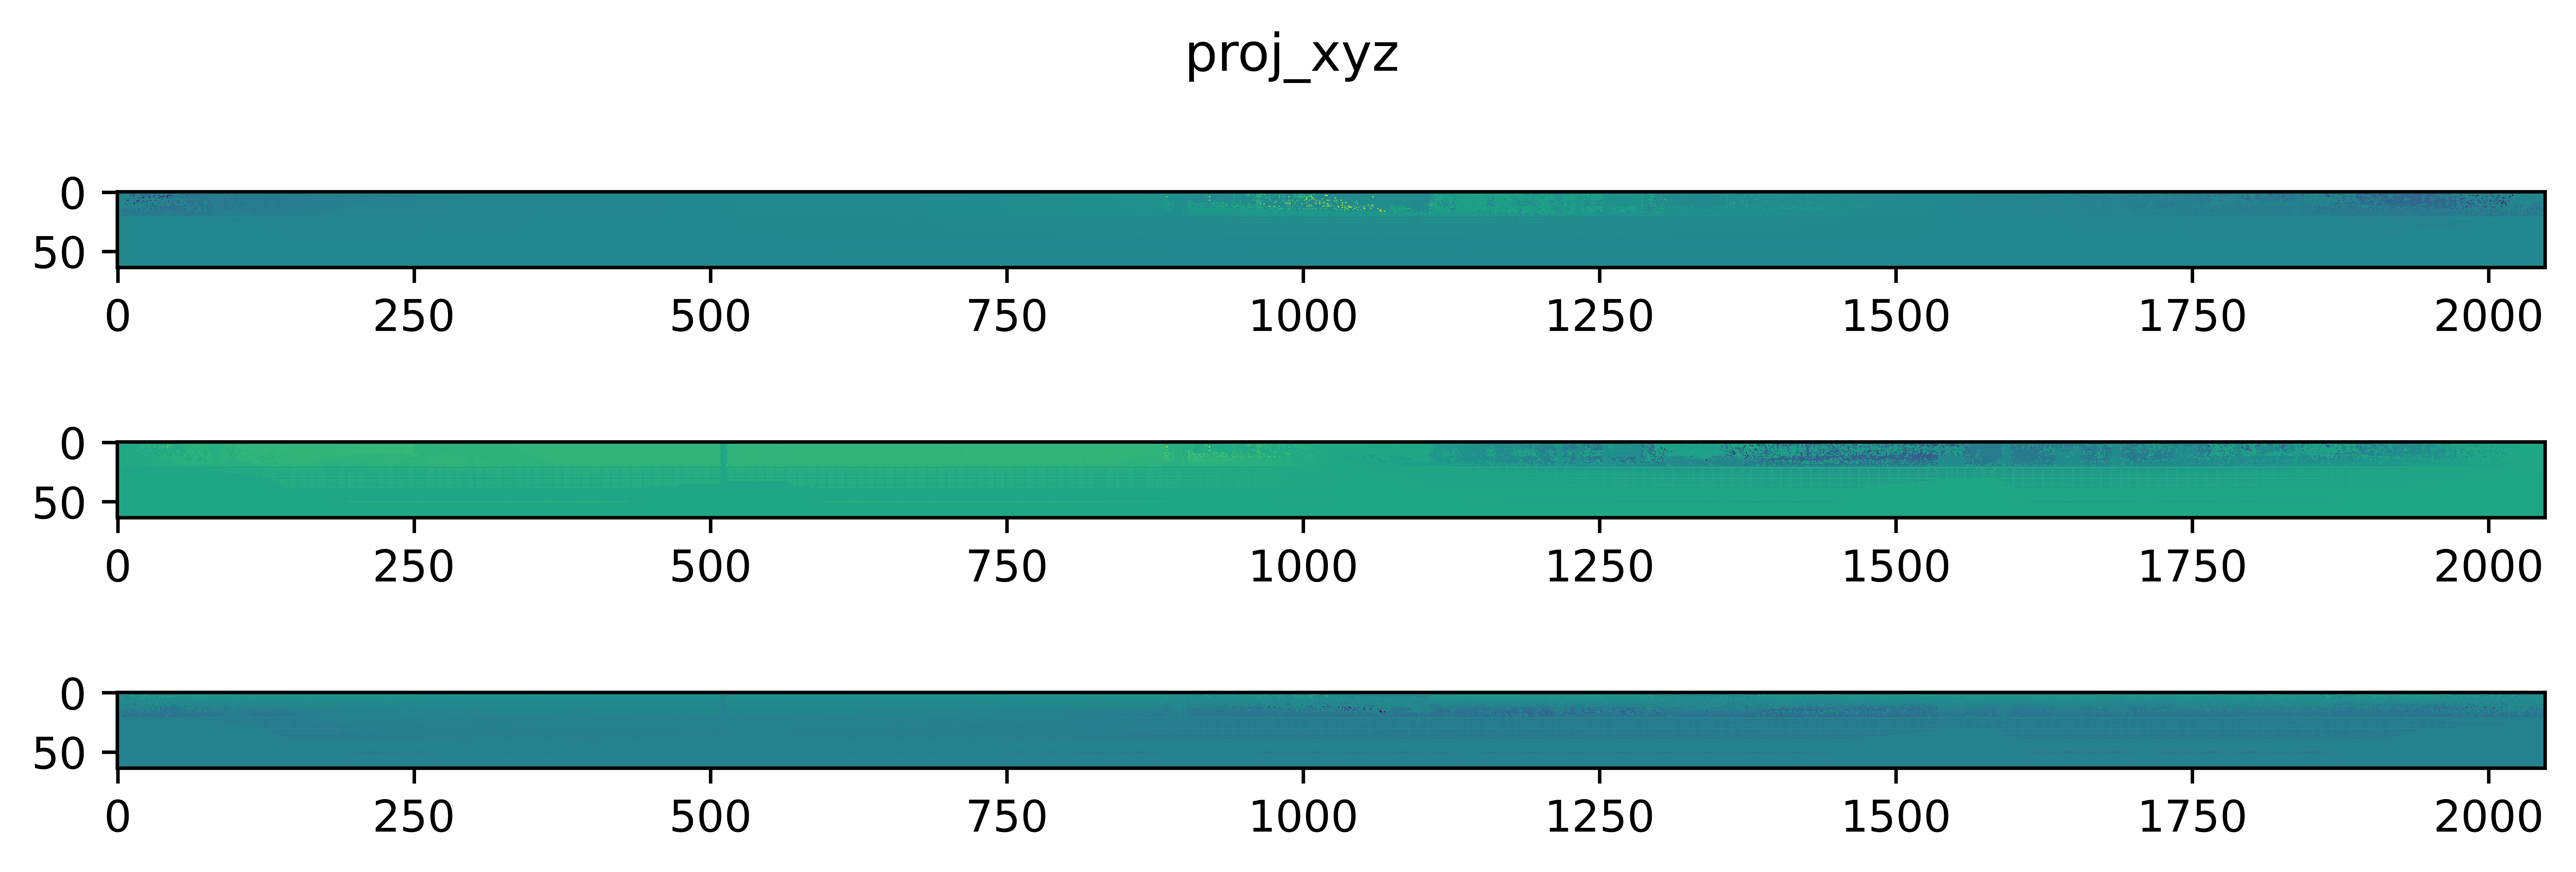

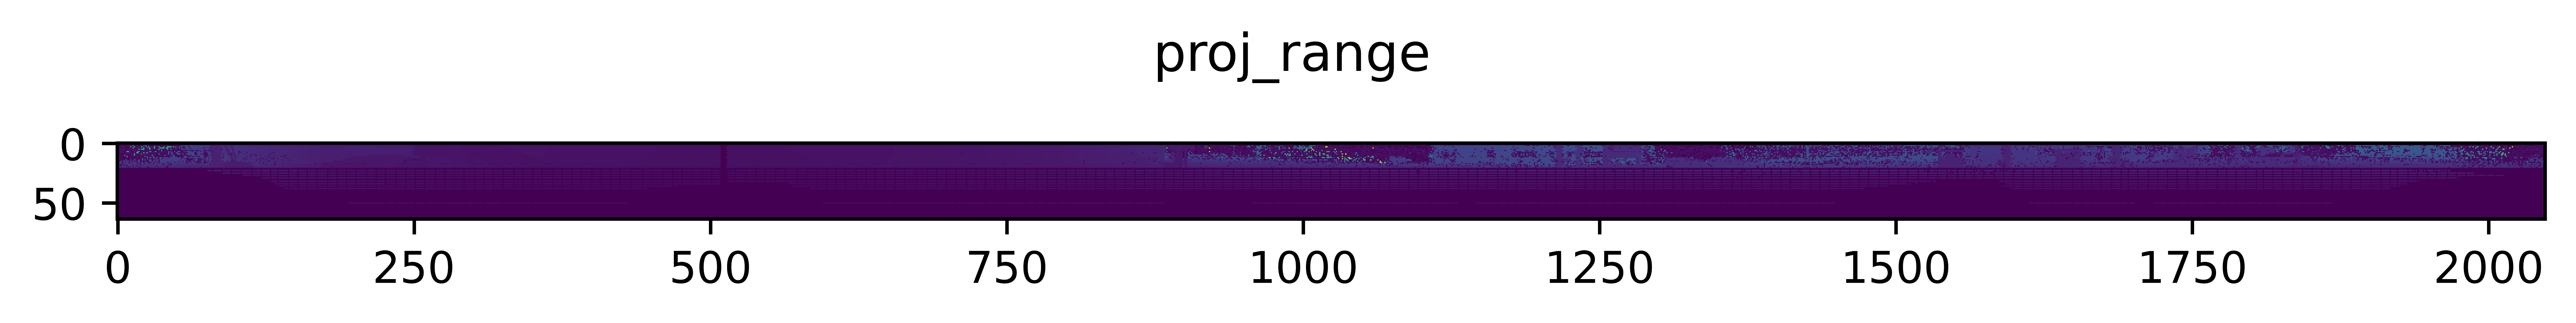

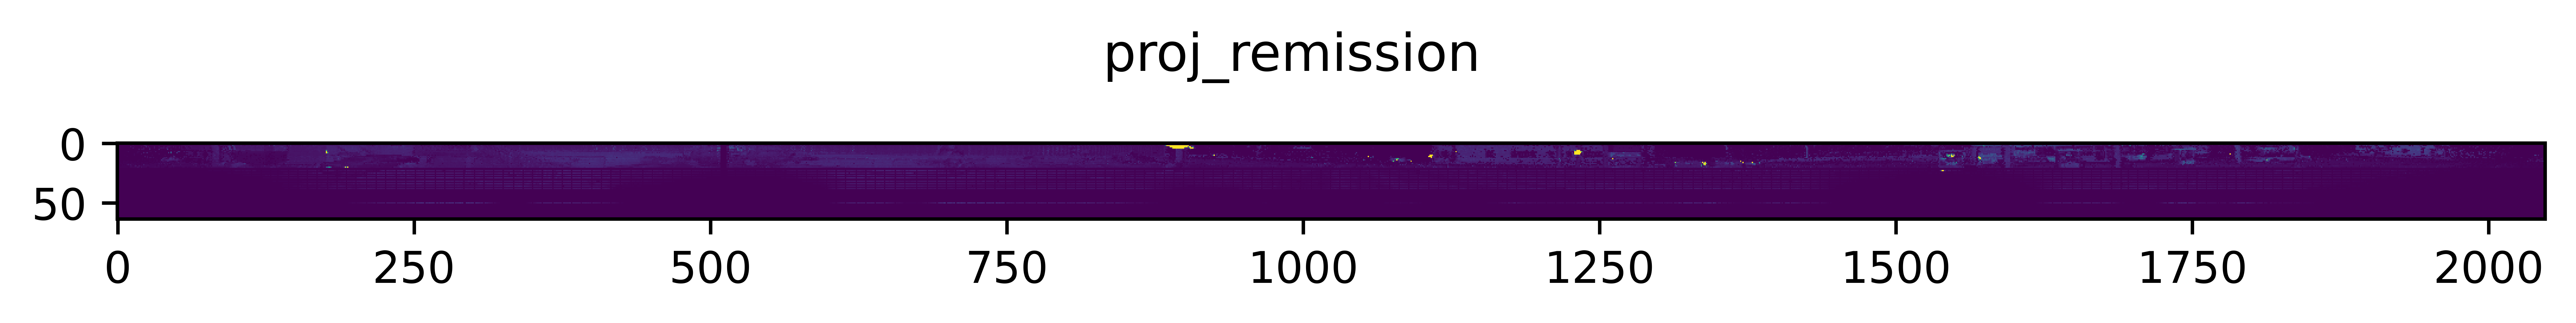

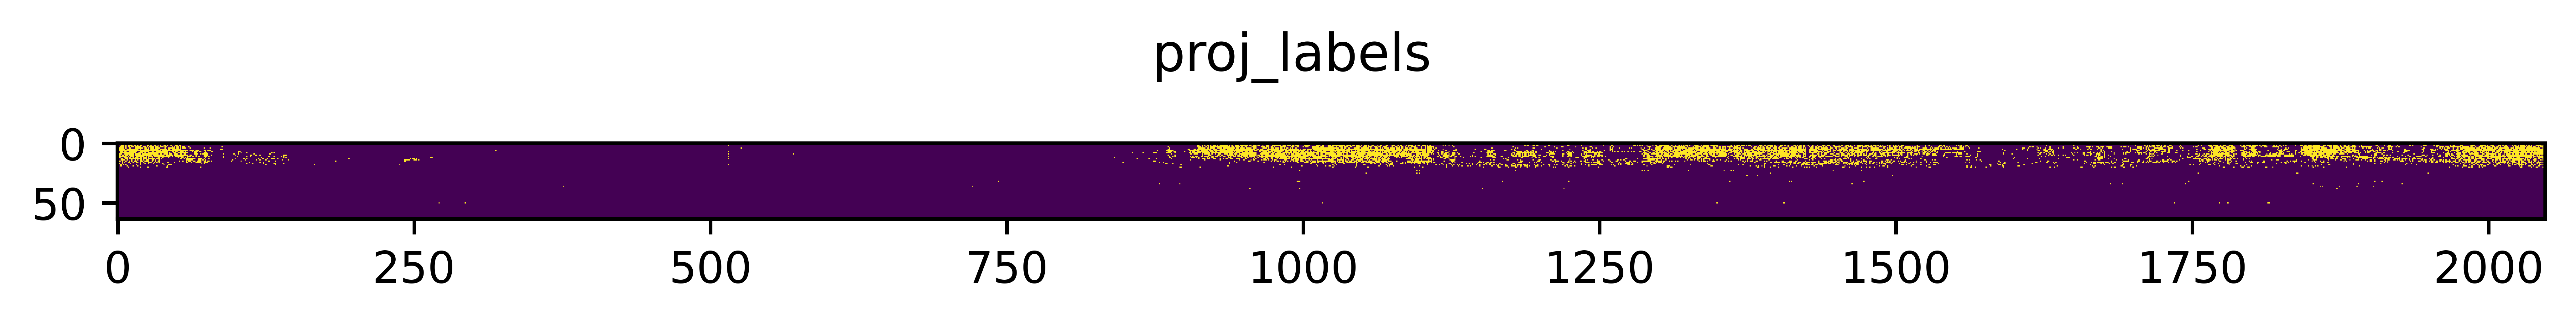

In [7]:
fig, axes = plt.subplots(nrows=3, figsize=(10, 3), dpi=1000)
for i in range(3):
    axes[i].imshow(sample.proj_xyz[i, :, :])
fig.suptitle("proj_xyz")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(sample.proj_range))
fig.suptitle("proj_range")

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(sample.proj_remission))
fig.suptitle("proj_remission");

fig, ax = plt.subplots(figsize=(10, 1), dpi=1000)
ax.imshow(torch.squeeze(sample.proj_labels))
fig.suptitle("proj_labels");

# Model and Training

In [8]:
hparams = {'train_ds': train_ds,
           'valid_ds': valid_ds,
           'test_ds': test_ds,
           'train_batch_size': 2,
           'valid_batch_size': 1,
           'test_batch_size': 1,
           'train_shuffle': True,
           'valid_shuffle': False,
           'test_shuffle': False,
           'num_workers': 20}

train_dataloader = WADSLoader(**hparams).train_dataloader()
valid_dataloader = WADSLoader(**hparams).validation_dataloader()
test_dataloader = WADSLoader(**hparams).test_dataloader()

batch = next(iter(train_dataloader))

print(batch.proj_xyz.shape)
print(batch.proj_range.shape)
print(batch.proj_remission.shape)
print(batch.proj_labels.shape)

torch.Size([2, 3, 64, 2048])
torch.Size([2, 1, 64, 2048])
torch.Size([2, 1, 64, 2048])
torch.Size([2, 1, 64, 2048])


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
# num_classes=1 using sigmoid
model =  WeatherNet(num_classes=1)
# Multi-GPU Training
model= nn.DataParallel(model)
model.to(device);

In [10]:
optimizer = Adam(model.parameters(), lr=0.3)
criterion = nn.BCELoss()
writer = SummaryWriter()
scheduler = ExponentialLR(optimizer, gamma=0.999)
sigmoid = nn.Sigmoid()

In [11]:
epochs = 100
train_ious = []
valid_ious = []
train_losses = []
valid_losses = []
best_loss = 100
best_iou = 0
saved = False

for epoch in range(epochs):
    print(Fore.YELLOW + f"Epoch: {(epoch+1):02}/{epochs}")
    for step, (proj_in, proj_mask, proj_labels, unproj_labels, path_seq, path_name, p_x, p_y, proj_range, unproj_range, proj_xyz, unproj_xyz, proj_remission, unproj_remissions, npoints) in enumerate(train_dataloader):
        # Use weighted BCE for class imbalance: weight = sqrt(frequency)
        label_0_freq = (proj_labels==0).sum().item()
        label_1_freq = (proj_labels==1).sum().item()
        weight = torch.where(proj_labels==0, 1/label_0_freq**0.5, 1/label_1_freq**0.5).to(device)
        criterion.weight = weight
        
        output = model(proj_range.to(device), proj_remission.to(device))
        output = sigmoid(output)
        pred = torch.where(output>=0.5, 1, 0)
        loss = criterion(output.float().to(device), proj_labels.float().to(device))
        iou = jaccard_index(proj_labels.cpu(), pred.cpu(), num_classes=2)
        
        optimizer.zero_grad()           
        loss.backward()                 
        optimizer.step()
        
        train_losses.append(loss.item())
        train_ious.append(iou.item())

        if ((step % (len(train_dataloader)//5)) == 0) or (step == len(train_dataloader)):
            train_loss = sum(train_losses)/len(train_losses)
            train_iou = sum(train_ious)/len(train_ious)
            writer.add_scalar('train_loss', train_loss, epoch * len(train_dataloader) + step)
            writer.add_scalar('train_iou', train_iou, epoch * len(train_dataloader) + step)
            train_losses.clear()
            train_ious.clear()
            
            model.eval() 
            with torch.no_grad():
                for proj_in, proj_mask, proj_labels, unproj_labels, path_seq, path_name, p_x, p_y, proj_range, unproj_range, proj_xyz, unproj_xyz, proj_remission, unproj_remissions, npoints in valid_dataloader:
                    criterion.weight = None
                    output = model(proj_range.to(device), proj_remission.to(device))
                    output = sigmoid(output)
                    pred = torch.where(output>=0.5, 1, 0)
                    loss = criterion(output.float().to(device), proj_labels.float().to(device))
                    iou = jaccard_index(proj_labels.cpu(), pred.cpu(), num_classes=2)
                    valid_losses.append(loss.item())
                    valid_ious.append(iou.item())
                
            valid_loss = sum(valid_losses)/len(valid_losses)
            valid_iou = sum(valid_ious)/len(valid_ious)
            writer.add_scalar('valid_loss', valid_loss, epoch * len(train_dataloader) + step)
            writer.add_scalar('valid_iou', valid_iou, epoch * len(train_dataloader) + step)
            valid_losses.clear()
            valid_ious.clear()
            
            if best_loss > valid_loss:
                best_loss = valid_loss
                best_model_loss = deepcopy(model.state_dict())
                torch.save(best_model_loss, "Best Model/best_model_2048_loss.pt")
                saved = True
                
            if best_iou < valid_iou:
                best_iou = valid_iou
                best_model_iou = deepcopy(model.state_dict())
                torch.save(best_model_iou, "Best Model/best_model_2048_iou.pt")
                saved = True
                
            if saved:
                print(Fore.GREEN + f"Training Loss(IoU): {train_loss:.6f}({train_iou*100:.2f}), Validation Loss(IoU): {valid_loss:.6f}({valid_iou*100:.2f})")
                saved = False
            else:
                print(Fore.RED + f"Training Loss(IoU): {train_loss:.6f}({train_iou*100:.2f}), Validation Loss(IoU): {valid_loss:.6f}({valid_iou*100:.2f})")

            model.train()
    
    scheduler.step()
    
    print(Fore.YELLOW + "=" * 74)

# Model Save and Load

In [12]:
torch.save(best_model_loss, "Best Model/best_model_2048_loss.pt")
torch.save(best_model_iou, "Best Model/best_model_2048_iou.pt")

In [13]:
model.load_state_dict(torch.load("Best Model/best_model_2048_iou.pt"))

<All keys matched successfully>

# Quantitative Evaluation

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate(model, dataloader):
    losses = []
    ious = []
    preds = []
    labels = []
    preds_flatten = []
    labels_flatten = []
    
    model.eval() 
    with torch.no_grad():
        for sample in dataloader:
            criterion.weight = None
            output = model(sample.proj_range.to(device), sample.proj_remission.to(device))
            output = sigmoid(output)
            pred = torch.where(output>=0.5, 1, 0)
            loss = criterion(output.float().to(device), sample.proj_labels.float().to(device))
            iou = jaccard_index(sample.proj_labels.cpu(), pred.cpu(), num_classes=2)
            
            preds.append(pred.cpu())
            labels.append(sample.proj_labels.cpu())
            
            losses.append(loss.item())
            ious.append(iou.item())

    loss = sum(losses)/len(losses)
    iou = sum(ious)/len(ious)
    
    
    # Concatenate all predictions and labels
    preds = torch.concat(preds, dim=0)
    labels = torch.concat(labels, dim=0)
    
    # Flattening predictions and labels to feed to classification_report
    for i in range(labels.shape[0]):
        labels_flatten.append(labels[i].squeeze().flatten())
        preds_flatten.append(preds[i].squeeze().flatten())
    
    # Concatenate all flattened predictions and labels
    preds_flatten = torch.concat(preds_flatten, dim=0)
    labels_flatten = torch.concat(labels_flatten, dim=0)
    
    # Print classification report and plot confusion matrix
    print(classification_report(labels_flatten, preds_flatten, labels=[0, 1]))
    cm = confusion_matrix(labels_flatten, preds_flatten, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot();
    
    return iou, loss, labels, preds

              precision    recall  f1-score   support

           0       0.99      1.00      0.99  12469538
           1       0.97      0.86      0.91    899806

    accuracy                           0.99  13369344
   macro avg       0.98      0.93      0.95  13369344
weighted avg       0.99      0.99      0.99  13369344

Validation IoU: 91.15%


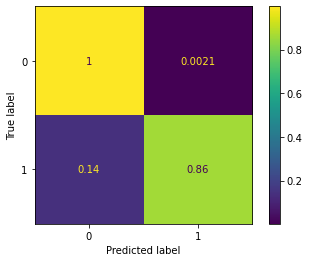

In [15]:
valid_iou, loss, labels, preds = evaluate(model, valid_dataloader)
print(f"Validation IoU: {valid_iou*100:.2f}%")

              precision    recall  f1-score   support

           0       0.99      1.00      0.99  50642205
           1       0.96      0.86      0.91   3097315

    accuracy                           0.99  53739520
   macro avg       0.98      0.93      0.95  53739520
weighted avg       0.99      0.99      0.99  53739520

Test IoU: 91.06%


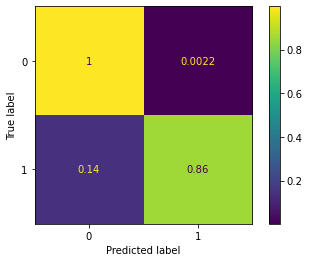

In [16]:
test_iou, loss, labels, preds = evaluate(model, test_dataloader)
print(f"Test IoU: {test_iou*100:.2f}%")

# Qualitative Evaluation 

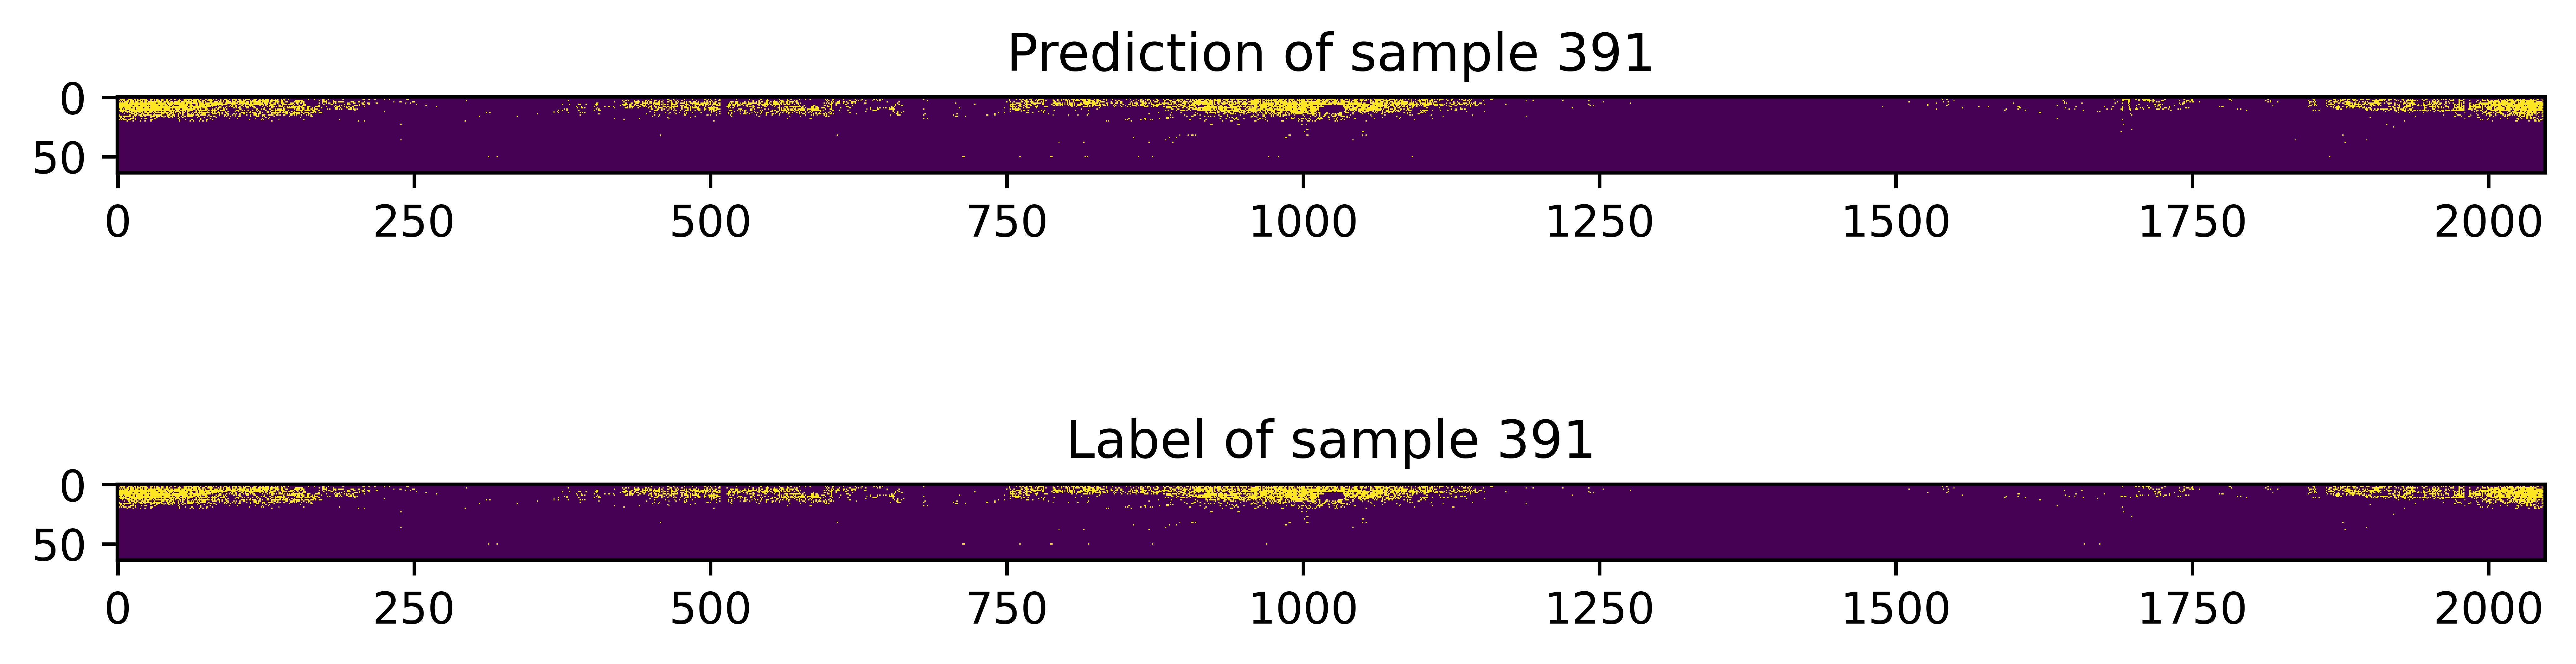

In [17]:
# Select a random rample for evaluation
idx = randint(0, labels.shape[0])

fig, axes = plt.subplots(figsize=(10,3), nrows=2, dpi=1000)
axes[0].imshow(preds[idx].cpu().squeeze())
axes[0].set_title(f"Prediction of sample {idx}");

axes[1].imshow(labels[idx].cpu().squeeze())
axes[1].set_title(f"Label of sample {idx}");

# Unprojection using KNN

In [18]:
knn_params = {'post': True,
              'knn': 5,
              'search': 11,
              'cutoff': 20,
              'sigma': 1.0}

In [19]:
# Code inspired by "https://github.com/Halmstad-University/SalsaNext/blob/master/train/tasks/semantic/modules/user.py"
def knn(dataloader, model, knn_params):
        proj_preds_list = []
        proj_labels_list = []
        unproj_preds_list = []
        unproj_labels_list = []
        
        postproc = KNN(knn_params, 2)
        
        model.eval()
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            for i, (proj_in, proj_mask, proj_labels, unproj_labels, path_seq, path_name, p_x, p_y, proj_range, unproj_range, proj_xyz, unproj_xyz, proj_remission, unproj_remissions, npoints) in enumerate(dataloader):
                p_x = p_x[0, :npoints]
                p_y = p_y[0, :npoints]
                proj_range = proj_range[0, :npoints].unsqueeze(1)
                unproj_range = unproj_range[0, :npoints]
                path_seq = path_seq[0]
                path_name = path_name[0]

                proj_in = proj_in.cuda()
                p_x = p_x.cuda()
                p_y = p_y.cuda()
                proj_range = proj_range.cuda()
                unproj_range = unproj_range.cuda()

                proj_output = sigmoid(model(proj_range, proj_remission))
                proj_argmax = torch.where(proj_output>0.5, 1, 0)

                torch.cuda.synchronize()


                unproj_argmax = postproc(proj_range.squeeze(),
                                         unproj_range.squeeze(),
                                         proj_argmax.squeeze(),
                                         p_x.squeeze(),
                                         p_y.squeeze())

                proj_labels_list.append(proj_labels.squeeze())
                proj_preds_list.append(proj_argmax.squeeze())

                unproj_labels_list.append(unproj_labels.squeeze()[: len(unproj_argmax)])
                unproj_preds_list.append(unproj_argmax)
                
        return proj_labels_list, proj_preds_list, unproj_labels_list, unproj_preds_list

In [20]:
proj_labels, proj_preds, unproj_labels, unproj_preds = knn(valid_dataloader, model, knn_params)

accs = []
for i in range(len(unproj_labels)):
    accs.append((((unproj_labels[i].cpu()==unproj_preds[i].cpu()).sum())/len(unproj_labels[i])).item())
print(f'Average validation accuracy: {(sum(accs)/len(accs))*100:.2f}%')

ious = []
for i in range(len(unproj_labels)):
    ious.append(jaccard_index(unproj_labels[i].cpu(), unproj_preds[i].cpu(), 2).item())
print(f'Average validation IoU: {(sum(ious)/len(ious))*100:.2f}%')

********************************************************************************
Cleaning point-clouds with kNN post-processing
kNN parameters:
knn: 5
search: 11
sigma: 1.0
cutoff: 20
nclasses: 2
********************************************************************************
Average validation accuracy: 98.10%
Average validation IoU: 90.83%


In [21]:
proj_labels, proj_preds, unproj_labels, unproj_preds = knn(test_dataloader, model, knn_params)

accs = []
for i in range(len(unproj_labels)):
    accs.append((((unproj_labels[i].cpu()==unproj_preds[i].cpu()).sum())/len(unproj_labels[i])).item())
print(f'Average test accuracy: {(sum(accs)/len(accs))*100:.2f}%')

ious = []
for i in range(len(unproj_labels)):
    ious.append(jaccard_index(unproj_labels[i].cpu(), unproj_preds[i].cpu(), 2).item())
print(f'Average test IoU: {(sum(ious)/len(ious))*100:.2f}%')

********************************************************************************
Cleaning point-clouds with kNN post-processing
kNN parameters:
knn: 5
search: 11
sigma: 1.0
cutoff: 20
nclasses: 2
********************************************************************************
Average test accuracy: 98.20%
Average test IoU: 90.35%
